## A/A тест

Есть данные А/А-теста с '2023-07-23' по '2023-07-29'. Нам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [1]:
import pandahouse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib #хеши
import swifter #ускорение
from scipy import stats
%matplotlib inline

In [2]:
#подключаемся к схеме данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230820',
    'user':'student',
    'password':'dpo_python_2020'
}

q = """
SELECT exp_group, 
    user_id,
    city,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230820.feed_actions 
WHERE toDate(time) between '2023-07-23' and '2023-07-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id, city
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df.head(5)

,exp_group,user_id,city,likes,views,ctr
0,3,112559,Kazan,37,136,0.272059
1,2,19368,Ramenskoye,26,117,0.222222
2,3,111834,Mariupol,11,35,0.314286
3,2,116352,Uray,17,79,0.215190
4,3,20374,Orenburg,14,113,0.123894


In [4]:
df.groupby('exp_group')['user_id'].nunique()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

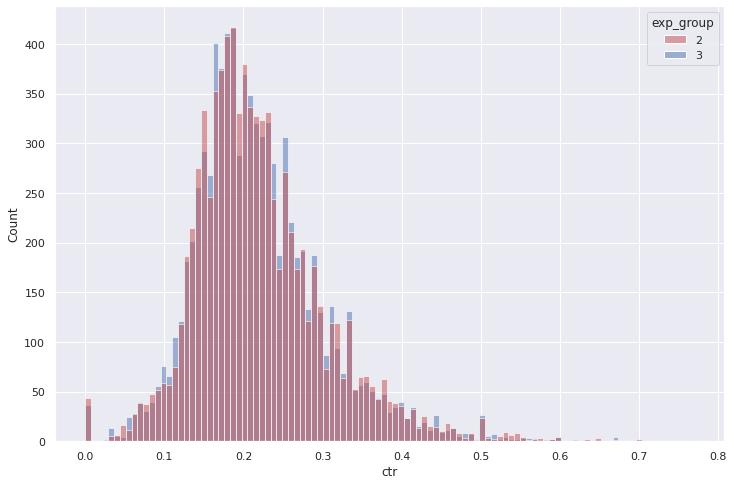

In [5]:
# графики в seaborn
sns.set(rc={'figure.figsize':(12,8)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Данные А/А-теста с '2023-07-23' по '2023-07-29'. Делаем симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации формируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проводим сравнение этих подвыборок t-testом.

__1. Построить гистограмму распределения получившихся 10000 p-values.__

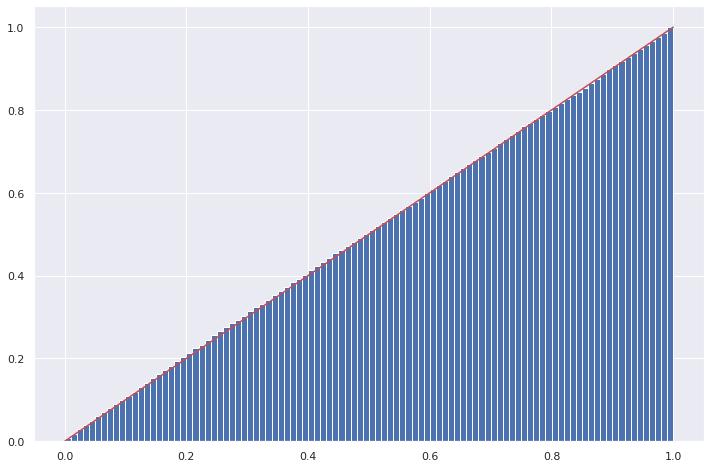

In [6]:
sample_size = 500
p_values = []
for _ in range(10000):
    a1 = np.random.choice(df[df.exp_group == 2].ctr, sample_size) #подвыборки без повторения в 500 юзеров
    a2 = np.random.choice(df[df.exp_group == 3].ctr, sample_size)
    p_values.append(stats.mannwhitneyu(a1, a2, alternative='two-sided').pvalue) #тест Манна-Уитни
    #p_values.append(stats.ttest_ind(a1, a2, equal_var=False).pvalue) #t-критерий Стьюдента

plt.hist(p_values, bins=100, cumulative=True, density=True);
plt.plot([0, 1], [0, 1], color='r');

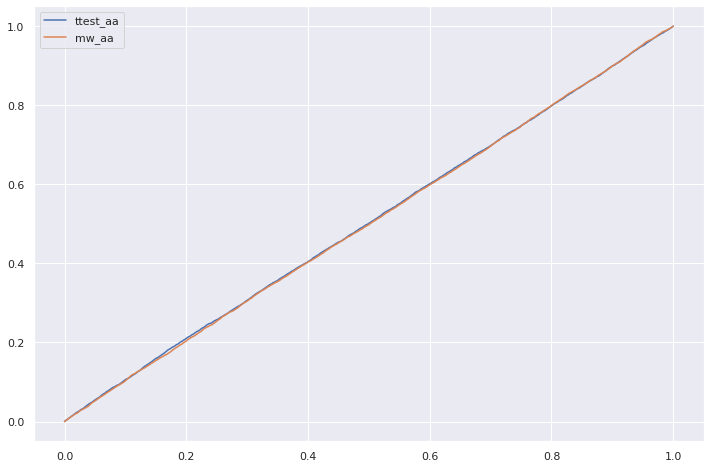

In [7]:
#график полученных распределений p-value по тесту Стьюдента и по тесту Манна-Уитни 
pvalues = {'ttest_aa': [], 'mw_aa': []}
for _ in range(10000):
    a1 = np.random.choice(df[df.exp_group == 2].ctr, sample_size)
    a2 = np.random.choice(df[df.exp_group == 3].ctr, sample_size)
    pvalues['ttest_aa'].append(stats.ttest_ind(a1, a2).pvalue) #тест Стьюдента
    pvalues['mw_aa'].append(stats.mannwhitneyu(a1, a2, alternative='two-sided').pvalue) #тест Манна-Уитни


X = np.linspace(0, 1, 1000)
for key, values in pvalues.items():
    values = np.array(values)
    Y = [np.mean(values < x) for x in X]
    plt.plot(X, Y, label=key)

plt.legend()
plt.show()

На графике видно, что p-value распределено равномерно, оба способа показывают корректные результаты.

__2. Посчитать, какой процент p-values оказался меньше либо равен 0.05__

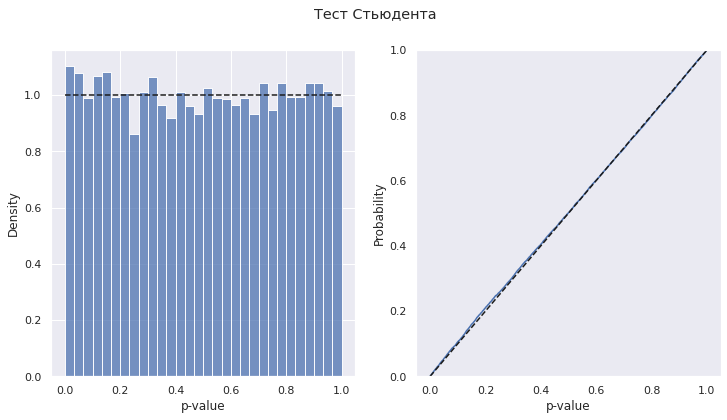

In [8]:
#визуализация на примере полученных значений p-value по тесту Стьюдента
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=30, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

# Вызов функции
plot_pvalue_ecdf(pvalues['ttest_aa'], title='Тест Стьюдента')

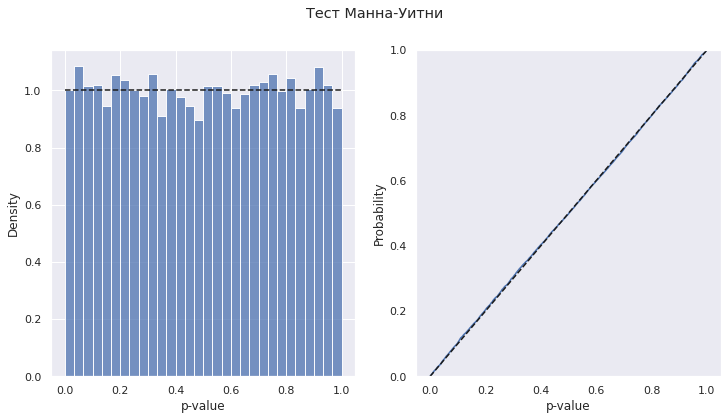

In [9]:
#визуализация на примере полученных значений p-value по тесту Манна-Уитни
plot_pvalue_ecdf(pvalues['mw_aa'], title='Тест Манна-Уитни')

In [10]:
#находим какой процент p-values оказался меньше либо равен 0.05
ttest_aa_pvalues = np.array(pvalues['ttest_aa'])
mw_aa_pvalues = np.array(pvalues['mw_aa'])

print('В тесте Стьюдента p-values оказался меньше либо равен 0.05 в', round((ttest_aa_pvalues <= 0.05).mean(), 3) * 100, '% случаев.')
print('В тесте Манна-Уитни p-values оказался меньше либо равен 0.05 в', round((mw_aa_pvalues <= 0.05).mean(), 3) * 100, '% случаев.')

В тесте Стьюдента p-values оказался меньше либо равен 0.05 в 5.5 % случаев.
В тесте Манна-Уитни p-values оказался меньше либо равен 0.05 в 5.2 % случаев.


__3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.__

По результатам проведенного А/А-теста, в котором сравнивали две одинаковые группы, получили следующие результаты:   
В тесте Стьюдента (t-тесте) p-value оказался меньше или равен 0.05 в 5.5% случаев.  
В тесте Манна-Уитни p-value оказался меньше или равен 0.05 в 5.2% случаев.   
Эти результаты говорят о том, что в небольшом проценте случаев (5.5% при использовании теста Стьюдента и 5.2% при использовании теста Манна-Уитни) мы наблюдали статистически значимые различия между двумя одинаковыми группами контроля. Такие различия не ожидаются в А/А-тесте, где группы должны быть идентичными. Вероятно, эти различия могут быть объяснены особенностями данных, маленькой выборкой или случайностью при проведении множественных экспериментов. Такие небольшие отклонения не считаются критичными, особенно если они происходят в небольшом проценте случаев, как в нашем.
Таким образом, данные могут считаться вполне корректными.